In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import e
import scipy

plt.style.use('ggplot')

np.random.seed(42)
%matplotlib inline

In this notebook, we're going to explore a few different concepts:

1. Differential Privacy versus the Laplace Mechanism: a way to sample "intelligent" noise (e.g. error) and insert it into the results to reduce privacy loss

2. Composition: or the ability to combine differentially private responses to reason about privacy loss (or information gain, depending on how you look at it!)

3. How we can calculate a privacy budget using the above concepts! A privacy budget (or privacy accountant) allows us to limit the amount of privacy loss for an individual over the course of several queries.

To do so, we will first create an artificial dataset of ages and salar

In [4]:
mid_level_age = 45
mid_level_salary = 50000

age_scale = 10 #scale represents one standard deviation
salary_scale = 10000

salaries = [round(np.random.normal(mid_level_salary,salary_scale)) for _ in range(100)]
ages = [round(np.random.normal(mid_level_age,age_scale)) for _ in range(100)]

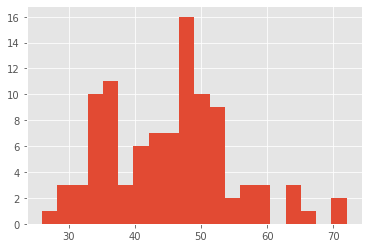

In [5]:
plt.hist(ages, bins=20);

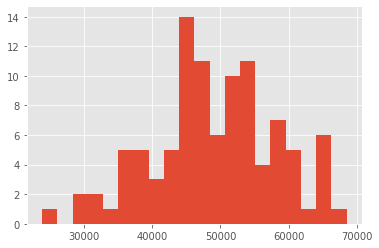

In [6]:
plt.hist(salaries, bins=20);

### Laplace Mechanism

Let's take a look at the Laplace mechanism for implementing differential privacy and notice the properties it gives us!

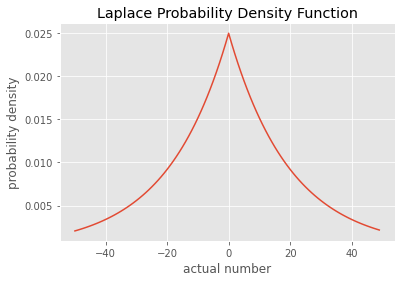

In [7]:
loc = 0
scale = 20

x = np.arange(-50., 50., 1)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)

fig,ax= plt.subplots()
ax.plot(x, pdf);
ax.set_title('Laplace Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

Depending on the Mu and b values, we can see how the distribution changes, and how this might then affect our results.

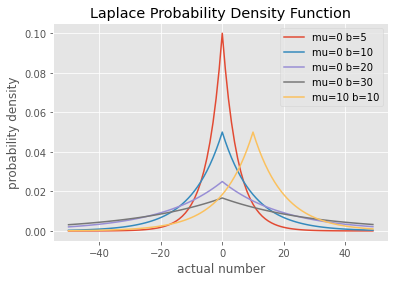

In [8]:
mu = [0, 0, 0, 0, 10]
b = [5, 10, 20, 30, 10]

x = np.arange(-50., 50., 1)
fig,ax= plt.subplots()


for mu_val, b_val in zip(mu, b):
    pdf = np.exp(-abs(x-mu_val)/b_val)/(2.*b_val)
    ax.plot(x, pdf, label='mu=%s b=%s' % (mu_val, b_val))
    
ax.set_title('Laplace Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density')
ax.legend()

Let's create a very naive differential privacy mechanism, that samples from Laplace and adds the noise to the result. Please note, do not use this with any real data! Instead use a well-known and audited open-source library!

NOTE: this is an incorrect usage of laplace, please do not use in a real problem! 

In [9]:
epsilon = 1.1
sensitivity = 1 

def laplace_dp_mechanism(value, epsilon, sensitivity=sensitivity):
    # Please do not use this function in real life - it is susceptible to well known attacks
    # instead, use a well-known and audited open-source DP library 
    orig_value = value
    value =  np.random.laplace(value, sensitivity/epsilon)
    #print("Noise: {}".format(value - orig_value))
    return value

In [10]:
laplace_dp_mechanism(np.mean(salaries), epsilon)

48962.807692233946

In [11]:
laplace_dp_mechanism(np.mean(ages), epsilon)

45.87717006163066

What is your guess of the actual mean?

In [12]:
np.mean(ages)

45.28

How could we measure something like correlation? One way would be to add noise to each of the salaries and ages, and then run our corrcoef. This is similar to creating "local differential privacy" solutions that allow differential privacy to be applied where data is collected. 

The problem with this approach is that it will add a large amount of noise compared with a more intelligent design if we already have the data at hand.

### Exploring Sensitivity and Error

When we want to release data in a differentially privacy way, we need to think about the sensitivity of the result. This is how much one person can change the result of a query. 

Our error / noise insertion needs to scale with this sensitivity in order for the differential privacy guarantee to hold (i.e. that with one addition or removal to the data, I cannot get "too much" more information based on the query result).

Sensitivity is how much one person (or privacy unit) can change the results. As you can see, we've been using sensitivity improperly! Let's choose something that is easy to define. 

In [13]:
new_ages = ages + [round(np.random.normal(mid_level_age,age_scale))]

In [15]:
len(new_ages) - len(ages)

1

Now our sensitivity is correct!

### Composition

So how do we reason about how much privacy loss there is when we answer a series of questions about the data? Differential privacy promises that we can track and measure privacy loss, so how do we do this?

One amazing property of differential privacy is that the epsilon value (ε) is our privacy loss for one particular response and it has the property of being individual to each query and yet composable -- meaning if I answer two queries, I can add their epsilons to calculate the privacy loss!

What does this mean in practice? 

1. Privacy budgets! I can budget my total epsilon appropriately over the course of a certain amount of queries. This means I can detemine how much information gain / privacy loss someone has when given multiple queries across the data.

2. The privacy loss is only for the individuals contained in the query response. This means I could also count the budget per individual and stop including those individuals in the responses once their budget has been reached. Of course, this will likely than bias my data as more individuals "drop out" when their budgets are reached.

3. Depending on what epsilon I come up with, I may want to spend more of it on a particular query than others. So if I know the queries in advance or if I am releasing data all at once, I may want to allocate my budget on a query by query basis!

In [12]:
sensitivity=1
total_privacy_budget = 1.1
num_queries = 10
per_query = total_privacy_budget / num_queries
print(per_query)

0.11000000000000001


In [18]:
counts = [laplace_dp_mechanism(len(ages), per_query) for _ 
         in range(num_queries)]

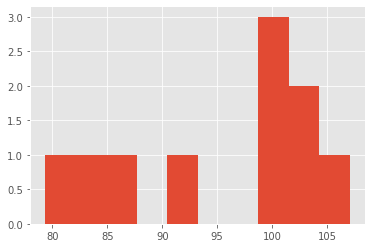

In [19]:
plt.hist(counts);

### Challenge

So far we've investigated the ages dataset. Try answering some basic questions about the salaries dataset using the (very simple and slightly broken) Laplace mechanism we've defined here. Some starting points might be:

- What is the average salary? 
- What is the correlation between age and salary? 
- What is the average salary of people over 40?
- What is the average salary for people under 40?

To do so, you might first want to link the datasets. I have written some example code below to help you get started! 

In [22]:
my_budget = 1.1

# Try tracking your budget as you answer the above. Think about how you spend it wisely!!! 

In [23]:
linked_dataset = np.column_stack((ages, salaries))

In [24]:
over_40 = linked_dataset[(linked_dataset[:,0] > 40)]

In [31]:
num_employees_over_40 = laplace_dp_mechanism(len(over_40[:,1]), 0.6, sensitivity=1)
num_employees_over_40

66.97815255294263

In [32]:
len(over_40[:,1])

68

In [75]:
#keeping my budget honest!
my_budget -= 0.6

In [ ]:
my_budget

### Recommended Reading

- Ted on Privacy's Blog Series on Differential Privacy! https://desfontain.es/privacy/friendly-intro-to-differential-privacy.html